<a href="https://colab.research.google.com/github/SamarSaeed1146/Internet_Chatbot/blob/main/Internet_Chatbot_With_Short_Memory_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -qU langchain langgraph langchain_google_genai tavily-python langchain_community

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_PROJECT"] = 'internet_memory'
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=gemini_api_key,
    max_retries=2,
    temperature=0.5,
)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is langgraph")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents in a structured and efficient manner. Learn how to install, use, and customize LangGraph to build complex, scalable, and flexible multi-agent systems.'},
 {'url': 'https://www.langchain.com/langgraph',
  'content': 'LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks.'}]

In [5]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

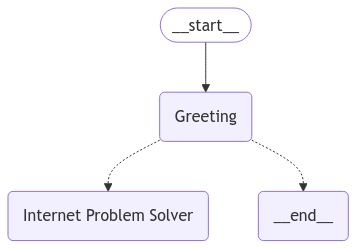

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from typing_extensions import Annotated, TypedDict

session_memory = {}

def internet_problem_solver(user_input: str):
    if "internet" not in user_input.lower():
        return "I can only assist with internet-related problems. Please ask about issues such as slow speeds, connection drops, or Wi-Fi setups."

    responses = []
    try:
        tool_response = tool.invoke(user_input)

        if tool_response:
            responses.append(f"{tool_response}")
    except Exception as e:
        print(f"Error invoking TavilySearchResults: {str(e)}")
        responses.append(f"Error with TavilySearchResults: {str(e)}")

    if responses:
        return "\n\n".join(responses)
    else:
        return "No meaningful response from tools or LLM."

def greeting_handler(user_input: str):
    greetings = ["hello", "hi", "hey", "greetings"]
    if any(greet in user_input.lower() for greet in greetings):
        return f"{user_input.capitalize()}! from Chat_internet How can I assist you today? If you have any internet-related issues, feel free to ask!"
    else:
        return "Redirecting to the Internet Problem Solver for your query."

def is_exit_command(user_input: str):
    exit_commands = ["quit", "exit", "q", "bye", "goodbye", "see you"]
    return any(cmd in user_input.lower() for cmd in exit_commands)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
graph_builder.add_node("Greeting", greeting_handler)
graph_builder.add_node("Internet Problem Solver", internet_problem_solver)
graph_builder.add_edge(START, "Greeting")
graph_builder.add_conditional_edges(
    "Greeting",
    {
        "Internet Problem Solver": lambda user_input: "internet" in user_input.lower(),
        END: lambda user_input: not ("internet" in user_input.lower())
    }
)
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
from pprint import pprint

while True:
    try:
        user_input = input("User: ").strip()
        if is_exit_command(user_input):
            pprint("Goodbye! Feel free to return anytime for Internet Problem Solving query.")
            break

        session_memory['last_query'] = user_input

        answer = internet_problem_solver(user_input) if "internet" in user_input.lower() else greeting_handler(user_input)
        pprint(f"Assistant: {answer}")
    except Exception as e:
        pprint(f"Error: {e}")

User: hi this is Samar
('Assistant: Hi this is samar! from Chat_internet How can I assist you today? '
 'If you have any internet-related issues, feel free to ask!')
User: what is internet
("Assistant: [{'url': 'https://www.techopedia.com/definition/2419/internet', "
 "'content': 'The Internet is a global network of interconnected computers and "
 'networks that enables communication and data services. Learn about its '
 'origin, evolution, key features, and popular services such as email, VoIP, '
 "and the World Wide Web.'}, {'url': "
 "'https://edu.gcfglobal.org/en/internetbasics/what-is-the-internet/1/', "
 "'content': 'Learn the definition, history, and features of the Internet, a "
 'global network of billions of devices. Find out how to access and use the '
 "Web, a collection of websites you can browse with a web browser.'}]")
User: what is langchain
'Assistant: Redirecting to the Internet Problem Solver for your query.'
User: okey bye
'Goodbye! Feel free to return anytime for I